**[OpenCV](https://opencv.org/) Utils**

In [1]:
import sys
import os

In [2]:
import numpy as np

In [3]:
import cv2 as cv

**Geometric Transformation**

In [4]:
def swap_br_channels(img):
    """CV uses BGR order, whereas the rest of world uses RGB
       Restore sanity.
    """
    if len(img.shape) >= 3:
        return img[:, :, [2,1,0], ...]
    else:
        return img

In [5]:
def _center_pts(pts):
    """Shift coordinates to center points h,v
    """
    xs = pts[:, 0]
    ys = pts[:, 1]
    x_off = (1 - (np.max(xs) + np.min(xs)))/2
    y_off = (1 - (np.max(ys) + np.min(ys)))/2
    pts[:, 0] += x_off
    pts[:, 1] += y_off
    return pts

def _add4(pts012):
    """Add the 4th point to a triple defining a affine region
    """
    pts012 = np.float32(pts012)
    pts3 = (pts012[0] + pts012[2] - pts012[1]).reshape(1, -1)
    return np.concatenate((pts012, pts3))

def affine_transform(
    img, 
    dst=[(0, 0), (1, 0), (1, 1)], 
    src=[(0, 0), (1, 0), (1, 1)], 
    fill=-1,
    recenter=True):
    """Perform affine transform
    img: source image
    dst: [(x0, y0), (x1, y1), (x2, y2)], xi, yi = 0..1
         Dst points to map to src [(0, 0), (1, 0), (1, 1)]
         They will be scaled by width and height
    fill: fill value
    """
    
    # Compute 4th point and apply perspective:
    dst4 = _add4(dst)
    src4 = _add4(src)
    return perspective_transform(img, dst=dst4, src=src4, fill=fill, recenter=recenter)

def perspective_transform(
    img, 
    dst=[(0, 0), (1, 0), (1, 1), (0, 1)], 
    src=[(0, 0), (1, 0), (1, 1), (0, 1)],
    fill=-1,
    recenter=True):
    """Perform perspective transform
    
    img: source image
    dst: [(x0, y0), (x1, y1), (x2, y2), (x3, y3)], xi, yi = 0..1
         Dst points to map to src [(0, 0), (1, 0), (1, 1), (0, 1)]
         They will be scaled by width and height
    fill: fill value
    """
    
    height, width = img.shape[:2]
    if fill == -1:
        fill = [255] * img.shape[2] if len(img.shape) > 2 else 255
    pts1 = np.float32(src)
    pts2 = np.float32(dst)
    if recenter:
        pts1 = _center_pts(pts1)
        pts2 = _center_pts(pts2)
    pts1[:, 0] *= width
    pts1[:, 1] *= height
    pts2[:, 0] *= width
    pts2[:, 1] *= height
    M = cv.getPerspectiveTransform(pts1, pts2)
    return cv.warpPerspective(img, M, (width, height), borderValue=fill)

def scale_transform(img, sx=1, sy=1):
    return perspective_transform(
        img, 
        dst=[(0, 0), (sx, 0), (sx, sy), (0, sy)]
    )

def rotate_transform(img, angle=0, fill=-1, scale='auto'):
    height, width = img.shape[:2]
    if fill == -1:
        fill = [255] * img.shape[2] if len(img.shape) > 2 else 255
    if scale == 'auto' or not scale or scale < 0:
        # Compute the scale such that the rotated image fits
        # the original rectangle:
        r = height / width # aspect ratio
        corners = np.array([[0, 0], [1, 0], [1, r], [0, r]]).T
        M = cv.getRotationMatrix2D((.5, .5*r), angle, 1)
        rot_corners = np.matmul(M, np.vstack((corners, [1, 1, 1, 1]))).T
        rot_x = rot_corners[:,0]
        rot_y = rot_corners[:,1]
        scale = min(1/(rot_x.max() - rot_x.min()), r/(rot_y.max() - rot_y.min()))
    center = (width//2, height//2)
    M = cv.getRotationMatrix2D(center, angle, scale)
    return cv.warpAffine(img, M, (width, height), borderValue=fill)

**Test**

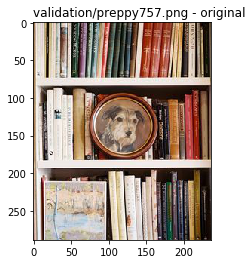

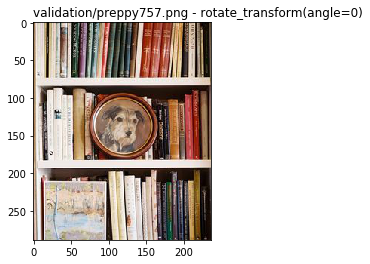

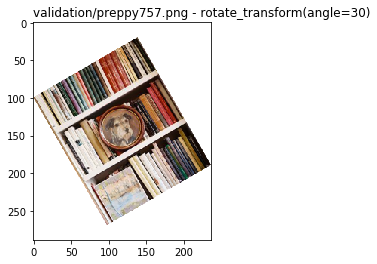

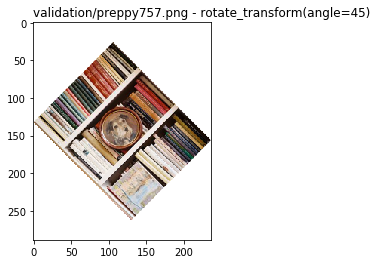

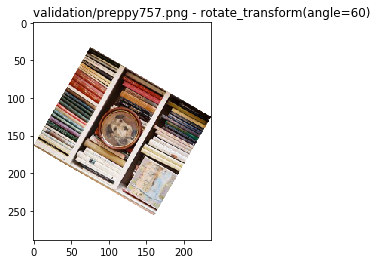

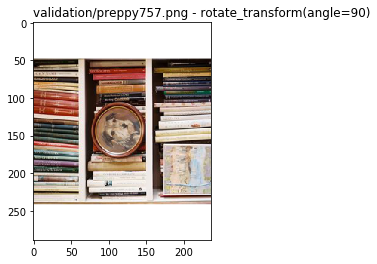

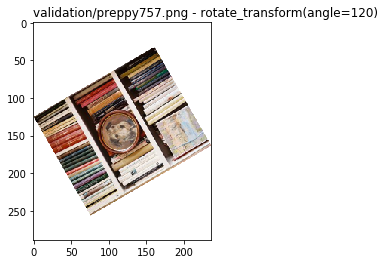

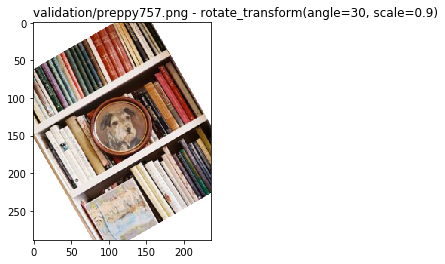

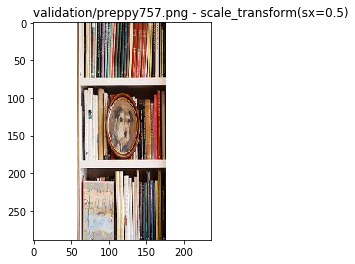

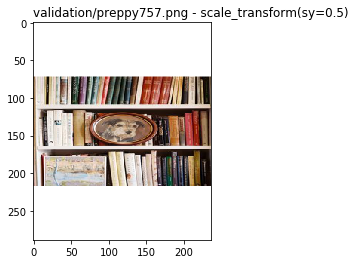

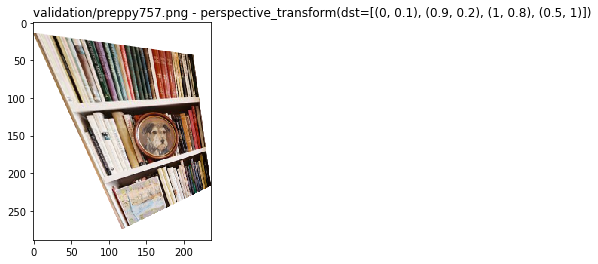

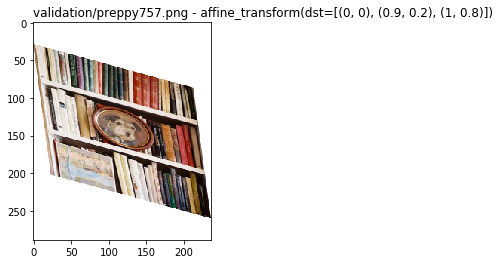

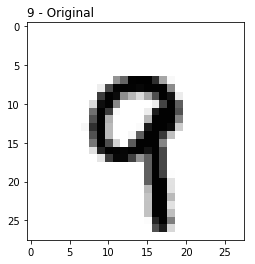

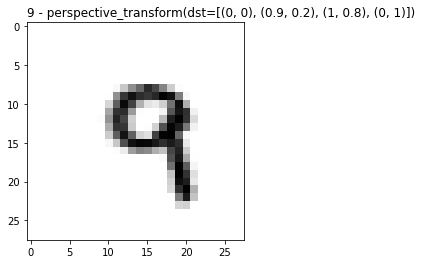

In [7]:
if __name__ == '__main__':
    import pil_utils
    
    imgs = pil_utils.load_zip_archive('data/interiors/validation.zip', 
                                      file_list='validation/preppy757.png')
    pil_img, pil_img_name = imgs[0]
    
    pil_utils.plot_image(pil_img, title='{} - original'.format(pil_img_name))

    for angle in [
        0,  30, 45, 60, 90, 120
    ]:
        t_pil_img = rotate_transform(pil_img, angle=angle)
        pil_utils.plot_image(t_pil_img, title='{} - rotate_transform(angle={})'.format(pil_img_name, angle))
    angle = 30
    scale = .9
    t_pil_img = rotate_transform(pil_img, angle=angle, scale=scale)
    pil_utils.plot_image(t_pil_img, 
                         title='{} - rotate_transform(angle={}, scale={})'.format(pil_img_name, angle, scale))
    

    sx = 0.5
    t_pil_img = scale_transform(pil_img, sx=sx)
    pil_utils.plot_image(t_pil_img, title='{} - scale_transform(sx={})'.format(pil_img_name, sx))

    sy = 0.5
    t_pil_img = scale_transform(pil_img, sy=sy)
    pil_utils.plot_image(t_pil_img, title='{} - scale_transform(sy={})'.format(pil_img_name, sy))

    dst = [(0, 0.1), (.9, .2), (1, .8), (.5, 1)]
    t_pil_img = perspective_transform(pil_img, dst=dst)
    pil_utils.plot_image(t_pil_img, title='{} - perspective_transform(dst={})'.format(pil_img_name, dst))
    
    dst = [(0, 0), (.9, .2), (1, .8)]
    t_pil_img = affine_transform(pil_img, dst=dst)
    pil_utils.plot_image(t_pil_img, title='{} - affine_transform(dst={})'.format(pil_img_name, dst))


    import mnist_utils
    mnist_imgs = mnist_utils.load_image_file('data/mnist/t10k-images-idx3-ubyte.gz')
    mnist_labels = mnist_utils.load_label_file('data/mnist/t10k-labels-idx1-ubyte.gz')
    
    i = 113
    mnist_img, mnist_img_name = mnist_imgs[i], mnist_labels[i]

    pil_utils.plot_image(mnist_img, title='{} - Original'.format(mnist_img_name))

    dst = [(0, 0), (.9, .2), (1, .8), (0, 1)]
    t_mnist_img = perspective_transform(mnist_img, dst=dst)
    pil_utils.plot_image(t_mnist_img, title='{} - perspective_transform(dst={})'.format(mnist_img_name, dst))

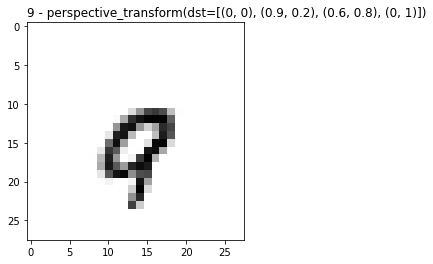

In [10]:
dst = [(0, 0), (.9, .2), (.6, .8), (0, 1)]
t_mnist_img = perspective_transform(mnist_img, dst=dst)
pil_utils.plot_image(t_mnist_img, title='{} - perspective_transform(dst={})'.format(mnist_img_name, dst))